### Load example video

In [1]:
from torchvision.io import read_video

In [2]:
video_path = "samples/bwdmzwhdnw.mp4"
video, audio, info = read_video(str(video_path), pts_unit="sec")

In [3]:
info

{'video_fps': 29.97, 'audio_fps': 48000}

In [4]:
video.shape  # (T, H, W, C)

torch.Size([300, 1080, 1920, 3])

In [5]:
audio.shape  # (C, T)

torch.Size([1, 480256])

### Load preprocessors

In [6]:
from utils import ImagePreprocessor, AudioPreprocessor

/Users/filipstrozik/Documents/studies/other/SynthWeave/.venv/lib/python3.12/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.3'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [7]:
img_processor = ImagePreprocessor(window_len=-1, device="cpu")
img_tensor = img_processor(video, info.get("video_fps", 30.0))
img_tensor.shape  # (N, C, H, W)

torch.Size([1, 3, 112, 112])

In [8]:
aud_processor = AudioPreprocessor(window_len=-1)
aud_tensor = aud_processor(audio, info.get("audio_fps", 16_000))
aud_tensor.shape  # (N, C, T)

torch.Size([1, 1, 160086])

### Load uni-modal models

In [9]:
from utils import ArcFace, ReDimNet
import torch

In [10]:
img_model = ArcFace()
img_model.eval()
aud_model = ReDimNet()
aud_model.eval()

/Users/filipstrozik/Documents/studies/other/SynthWeave/.venv/lib/python3.12/site-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'CoreMLExecutionProvider, AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}


Downloading: "https://github.com/IDRnD/ReDimNet/zipball/master" to /Users/filipstrozik/.cache/torch/hub/master.zip


/Users/filipstrozik/.cache/torch/hub/IDRnD_ReDimNet_master
load_res : <All keys matched successfully>


ReDimNet(
  (model): ReDimNetWrap(
    (backbone): ReDimNet(
      (stem): Sequential(
        (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (1): LayerNorm(C=(32,), data_format=channels_first, eps=1e-06)
        (2): to1d()
      )
      (stage0): Sequential(
        (0): weigth1d(w=(1, 1, 1, 1),sequential=False)
        (1): to2d(f=72,c=32)
        (2): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
        (3): ConvBlock2d(
          (conv_block): ResBasicBlock(
            (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=4, bias=False)
            (conv1pw): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
            (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=4, bias=False)
            (conv2pw): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
            (bn2): BatchN

In [11]:
with torch.no_grad():
    img_emb = img_model(img_tensor)
img_emb.shape

torch.Size([1, 512])

In [12]:
with torch.no_grad():
    aud_emb = aud_model(aud_tensor)
aud_emb.shape

torch.Size([1, 192])

### Load fusion module

In [ ]:
from synthweave.fusion import CFF, AFF, IAFF, CAFF, GFF

# or

from synthweave.utils import get_fusion
# macos wierd stuff with imports
# from synthweave.utils.fusion import get_fusion 

In [21]:
FUSION = "CFF"
EMB_DIM = 256

fusion = get_fusion(
    fusion_name=FUSION,
    output_dim=EMB_DIM,
    modality_keys=["image", "audio"],
    out_proj_dim=256,
    # num_att_heads=4,
)

# fusion.load_state_dict(torch.load("../../../models/fusion/CFF.pth"))

[INFO] This fusion expects embeddings of shape (batch_size, embed_dim).


### Construct pipeline

In [22]:
from synthweave.pipeline import BasePipeline

In [23]:
pipe = BasePipeline(
    processors={"image": img_processor, "audio": aud_processor},
    models={"image": img_model, "audio": aud_model},
    fusion=fusion,
    head=torch.nn.Sequential(torch.nn.Linear(256, 1), torch.nn.Sigmoid()),
)
pipe.eval()

BasePipeline(
  (feature_extractors): ModuleDict(
    (image): ArcFace()
    (audio): ReDimNet(
      (model): ReDimNetWrap(
        (backbone): ReDimNet(
          (stem): Sequential(
            (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
            (1): LayerNorm(C=(32,), data_format=channels_first, eps=1e-06)
            (2): to1d()
          )
          (stage0): Sequential(
            (0): weigth1d(w=(1, 1, 1, 1),sequential=False)
            (1): to2d(f=72,c=32)
            (2): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
            (3): ConvBlock2d(
              (conv_block): ResBasicBlock(
                (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=4, bias=False)
                (conv1pw): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
                (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                (conv2): Conv2d(128, 128, kernel_size=(3, 3),

### Run the pipeline

In [24]:
reference_sample = "samples/zfobicuigx.mp4"
fake_sample = "samples/bwdmzwhdnw.mp4"

ref_video, ref_audio, ref_info = read_video(str(reference_sample), pts_unit="sec")
fake_video, fake_audio, fake_info = read_video(str(fake_sample), pts_unit="sec")

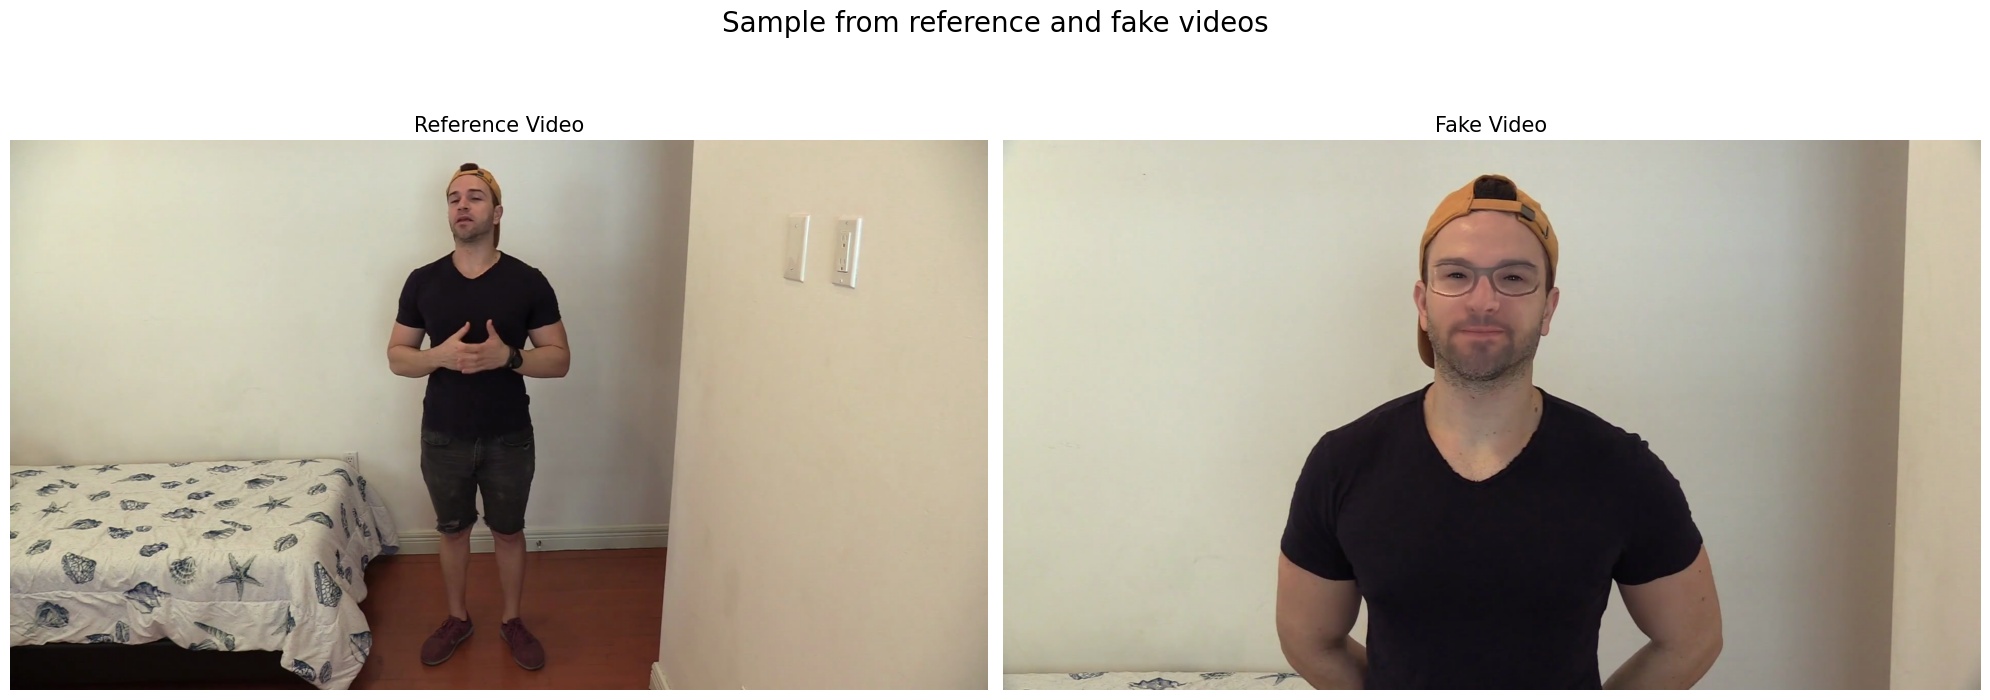

In [25]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(20, 8))

plt.suptitle("Sample from reference and fake videos", fontsize=20)

axs[0].imshow(ref_video[0])
axs[0].axis("off")
axs[0].set_title("Reference Video", fontsize=15)

axs[1].imshow(fake_video[0])
axs[1].axis("off")
axs[1].set_title("Fake Video", fontsize=15)

plt.tight_layout()
plt.show()

In [26]:
from IPython.display import Audio

print("Reference Audio")
Audio(ref_audio[0].numpy(), rate=ref_info.get("audio_fps", 16_000))
display(Audio(ref_audio[0].numpy(), rate=ref_info.get("audio_fps", 16_000)))

print("Fake Audio")
display(Audio(fake_audio[0].numpy(), rate=fake_info.get("audio_fps", 16_000)))

Reference Audio


Fake Audio


In [27]:
ref_inputs = {
    "image": (ref_video, ref_info.get("video_fps", 30.0)),
    "audio": (ref_audio, ref_info.get("audio_fps", 16_000)),
}

fake_inputs = {
    "image": (fake_video, fake_info.get("video_fps", 30.0)),
    "audio": (fake_audio, fake_info.get("audio_fps", 16_000)),
}

with torch.no_grad():
    ref_output = pipe.forward(ref_inputs, output_feats=True)
    fake_output = pipe.forward(fake_inputs, output_feats=True)

In [28]:
ref_output_img = ref_output["image"][0]
fake_output_img = fake_output["image"][0]

img_sim = img_model.compute_similarities(ref_output_img, fake_output_img)

print(f"Face Similarity: {img_sim:.2f}%")

Face Similarity: 99.92%


/Users/filipstrozik/Documents/studies/other/SynthWeave/examples/deepfake_detection/utils.py:106: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3641.)
  return np.dot(e_i, e_j.T) / (np.linalg.norm(e_i) * np.linalg.norm(e_j)) * 100


In [29]:
ref_output_aud = ref_output["audio"][0]
fake_output_aud = fake_output["audio"][0]

aud_sim = aud_model.compute_similarities(ref_output_aud, fake_output_aud)

print(f"Voice Similarity: {aud_sim:.2f}%")

Voice Similarity: 8.18%


In [30]:
print(f"Fake Probability: {fake_output["logits"].item()*100:.2f}%")

Fake Probability: 49.06%
